# Exploratory Data Analysis

 Let us start with some exploration of the data to check if any processing is needed and to get some insight on customer and fraudster behavior.
 Summary: the data is already clean, with no missing values and features that are already standardized. The extreme class imbalance (0.17% positives) calls for appropriate models and evaluation metrics.

In [2]:
## Database and libraries imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

df = pd.read_csv("../data/raw.csv")


## Basic Info

The database contains 284 807 samples, including 492 positives, made up of 31 features:  
  
-Time: Time of the transaction in seconds that elapsed since the first transaction in the dataset. The data spans two days (48 hours).  
-V1-V28: 28 features derived from the original data by the research team. They were PCA transformed to preserve customer privacy.  
-Amount: transaction amount (in Euros).  
-Class: 1 for a fraud, 0 for a non-fraud. 
  
  
Class imbalance is very high as expected: only 0.17% of transactions are tagged as fraudulent. Practically this means we will:  
  
-Use relevant metrics for evaluation (precision alone is meaningless; we will consider the Precision/Recall curve, the Receiver Operating Characteristic curve, or Recall@K/Precision@K)  
-Choose models that handle imbalance well ( e.g. gradient-boosted decision trees).
-Use class-balanced weights during training  
-Pay attention to the choice of the decision threshold  
  
There are no missing values and all Time/Amount values are positive, so no further preprocessing is necessary on this database. Features are already centered and standardized.

In [3]:
## Basic info

print("BASIC INFO:")

df.info()

print("")

## Missing values

print("MISSING VALUES: \n", df.isnull().sum(), "\n")

## Class imbalance

print("CALSS IMBALANCE:")
print(df["Class"].value_counts(normalize=True))
print(df["Class"].value_counts(normalize=False))

BASIC INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21

## Time plots

Let us now take a look at the spending behavior of genuine clients and fraudsters, starting with the transaction frequency. Though the time of the data is only relative, we can identify a clear diurnal pattern: legitimate clients make roughly 8 more transactions during the day. On the other hand, fraudsters' spending frequency seems to be independent of time, though the data is very noisy and harder to interpret. What is clear however is that the fraud rate raises sharply during nighttime hours.  
  
This analysis gives us some insight into what the features might be. We can imagine a feature tracking whether the transaction happened at night (00:00-06:00) for example, or some other feature tracking the usual night-time spending behavior of clients. A client being active at nighttime, contrary to his habits, would be a very strong fraud signal.  
  
This time-dependent behavior is also of practical relevance for model evaluation: we should be cautious when splitting data for training/testing/calibration sets. Training by day and evaluating by night would biais the performance estimates.

Text(0.5, 0, 'time (h)')

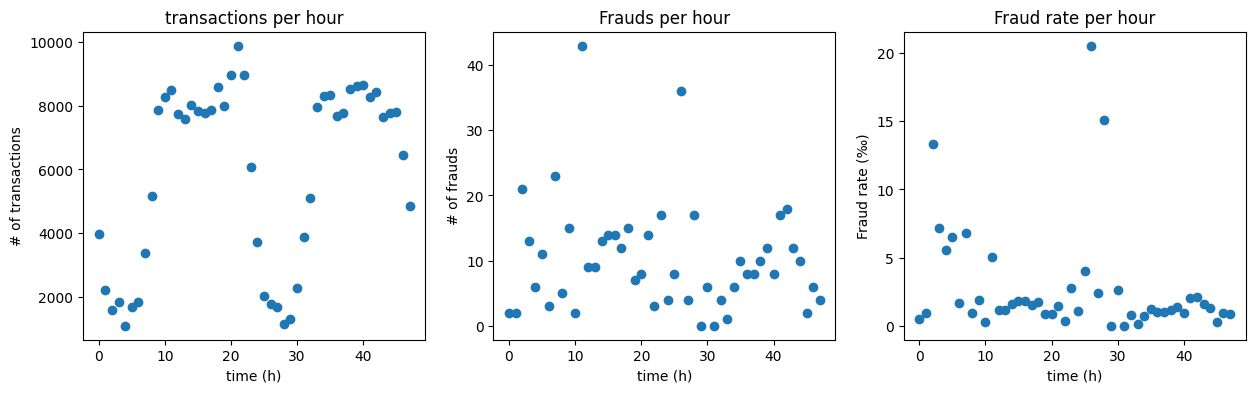

In [99]:

## Frauds per hour

time = [i for i in range(0, 48)] ## The data spans two days so 48 hours
frauds_per_hour = [0] * 48
transactions_per_hour = [0] * 48

for index, row in df.iterrows():
    hour = int(row["Time"] // 3600)
    transactions_per_hour[hour] += 1
    if row["Class"] == 1:
        frauds_per_hour[int(row["Time"] // 3600)] += 1

fraud_rate_per_hour = [frauds_per_hour[h] / transactions_per_hour[h] * 1000 for h in range(48)]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(time, transactions_per_hour)
axes[0].set_title("Transactions per hour")
axes[0].set_ylabel("# of transactions")
axes[0].set_xlabel("time (h)")

axes[1].scatter(time, frauds_per_hour)
axes[1].set_title("Frauds per hour")
axes[1].set_ylabel("# of frauds")
axes[1].set_xlabel("time (h)")

axes[2].scatter(time, fraud_rate_per_hour)
axes[2].set_title("Fraud rate per hour")
axes[2].set_ylabel("Fraud rate (‰)")
axes[2].set_xlabel("time (h)")


<div align="center">

**Figure - Time plots for transaction, frauds, and fraud rate per hour**

We can see a clear diurnal pattern in the spending behavior of clients - as well as fraudsters. 

</div>

## Amount distribution

We now turn to the amount distribution for some insight. Here we would normally draw a simple histogram of the data, but as most transactions happen around 1-10 €, and we find some transactions upwards of 10,000 €, this makes for a very unreadable graph (we still plot it for reference). On top of that, we as humans feel spending "neighborhoods" as more relative than fixed size bins. When someone reports sending "around 10 €", it might be 9 or 11. When that same person reports spending "around 100 €", it might be 95 or 105.  
  
To reflect this relative feeling and plot nicer graphs, let us study the distribution of log(amount + 1) instead of the raw amount.    
  
On top of the histogram, let us plot the KDE (Kernel Density Estimation) for log(1 + amount). The KDE corresponds to a 'smoothed out' version of the histogram, using a Gaussian sliding windows instead of bins. We also plot the empirical cumulative distribution function (ECDF) as a sanity check.  
  
For genuine transactions, we observe a strong peak around 1-2€ that corresponds to all the small day-to-day transactions. Then bigger transactions seem to peak "around" 30 euros, before slowly tapering off. I put quotes to "around" as a reminder that bin width here is relative: there are in fact more transactions at 8€ than at 30€, but there are more transactions in the range 30-40 than 8-9. This is reflected by a stronger slope around 30€ on the ECDF. 
  
For frauds, in contrast, the bulk of the transactions happens  under 1€, or over 100€, with less transactions in between. Low amounts can have two explanations: maybe the fraudster is just "trying out" the stolen card/credentials before moving on to higher amounts, or maybe they have a strategy to make lots of small transactions to fly under the radar (joke's on them this is even more suspicious). Higher amounts are self explanatory: fraudsters try to steal as much as they can before the fraud is uncovered. We can also see a strong discontinuity at 1€ and 100€ on the ECDF, suggesting cases where the fraudsters are setting the amount themselves, and not being very subtle about it.
  
Overall, spending behavior differs substantially between fraudsters and genuine costumers. But the simple indicators we plotted wouldn't be enough to discriminate between the two classes, which highlights the importance of proper feature engineering.

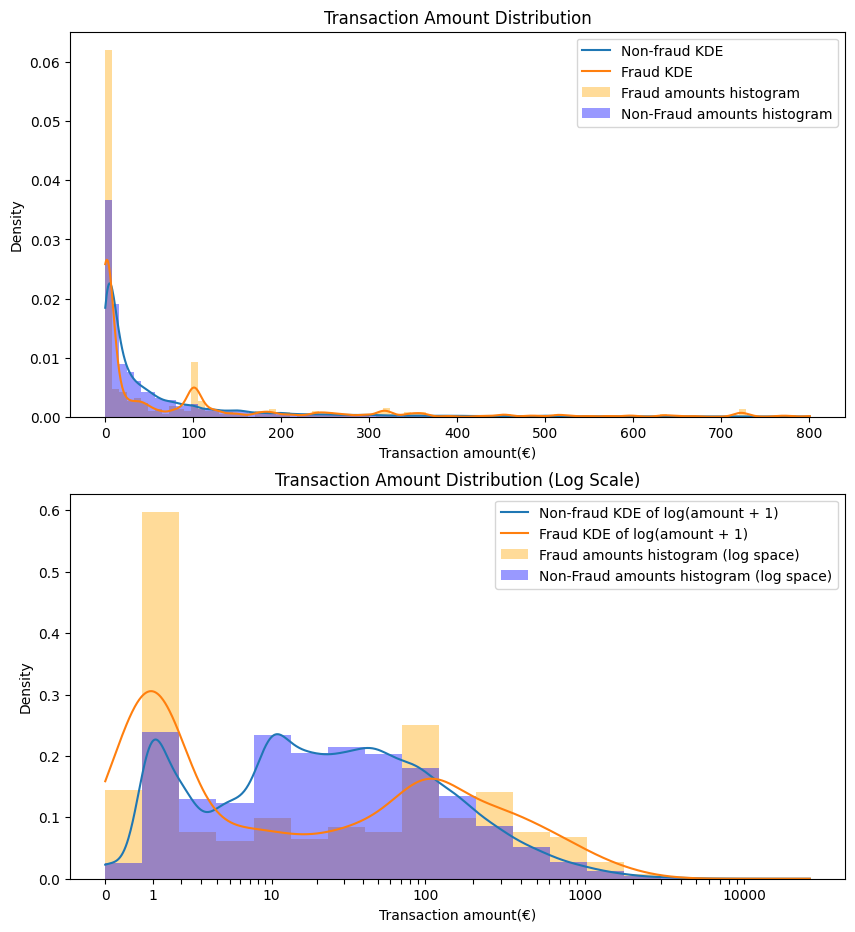

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(10, 11))

## KDE and histogram plots for the amount of transactions

amounts_clean = df[df["Class"]==0]["Amount"].values
amounts_fraud = df[df["Class"]==1]["Amount"].values

lim = 800

x = np.linspace(0, lim + 1, 1000)

kde_fraud = gaussian_kde(amounts_fraud)
kde_fraud.set_bandwidth(kde_fraud.factor * 0.1)
kde_non_fraud = gaussian_kde(amounts_clean)
kde_non_fraud.set_bandwidth(kde_non_fraud.factor * 0.3)

bins = np.linspace(0, lim + 1, 100)

ax[0].plot(x, kde_non_fraud(x), label="Non-fraud KDE")
ax[0].plot(x, kde_fraud(x), label="Fraud KDE")
ax[0].hist(amounts_fraud, bins=bins, density=True, alpha=0.4, color="orange", label="Fraud amounts histogram")
ax[0].hist(amounts_clean, bins=bins, density=True, alpha=0.4, color="blue", label="Non-Fraud amounts histogram")
ax[0].set_xlabel("Transaction amount(€)")
ax[0].set_ylabel("Density")
ax[0].set_title("Transaction Amount Distribution")
ax[0].legend()

## KDE and histogram plots for log(amount + 1)

amounts_clean = df[df["Class"]==0]["Amount"].values
amounts_fraud = df[df["Class"]==1]["Amount"].values
log_amounts_clean = np.log1p(amounts_clean)
log_amounts_fraud = np.log1p(amounts_fraud)

x = np.linspace(log_amounts_clean.min(), log_amounts_clean.max(), 1000)

kde_fraud = gaussian_kde(log_amounts_fraud)
kde_fraud.set_bandwidth(kde_fraud.factor * 0.75)
kde_non_fraud = gaussian_kde(log_amounts_clean)
kde_non_fraud.set_bandwidth(kde_non_fraud.factor * 1.5)

ticks_pos = np.log1p([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
ticks = [0, 1, '', '', '', '', '', '', '', '', 10, '', '', '', '', '', '', '', '', 100, '', '', '', '', '', '', '', '', 1000, '', '', '', '', '', '', '', '', 10000]
bins = np.linspace(log_amounts_clean.min(), log_amounts_clean.max(), 20)

ax[1].plot(x, kde_non_fraud(x), label="Non-fraud KDE of log(amount + 1)")
ax[1].plot(x, kde_fraud(x), label="Fraud KDE of log(amount + 1)")
ax[1].hist(log_amounts_fraud, bins=bins, density=True, alpha=0.4, color="orange", label="Fraud amounts histogram (log space)")
ax[1].hist(log_amounts_clean, bins=bins, density=True, alpha=0.4, color="blue", label="Non-Fraud amounts histogram (log space)")
ax[1].set_xticks(ticks_pos)
ax[1].set_xticklabels(ticks)
ax[1].set_xlabel("Transaction amount(€)")
ax[1].set_ylabel("Density")
ax[1].set_title("Transaction Amount Distribution (Log Scale)")
ax[1].legend()

<div align="center">

**Figure - Histograms and Kernel Estimated Distribution for Amount and log(Amount + 1)**

Fraudsters tend to spend under one euro or over 100 euros.

</div>

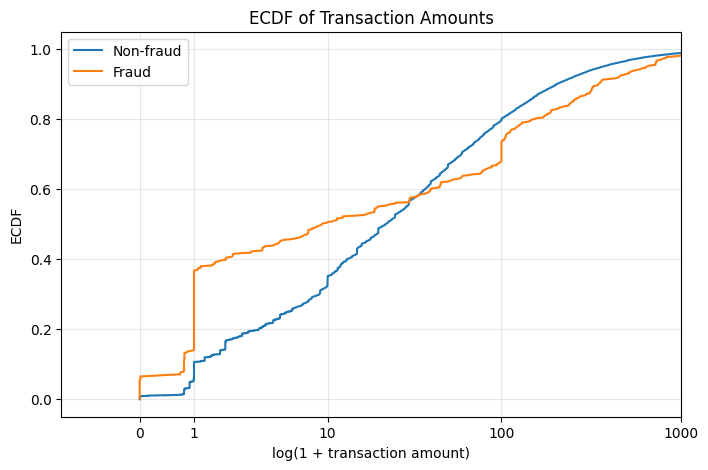

In [101]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

amounts_clean = df[df["Class"]==0]["Amount"].values
amounts_fraud = df[df["Class"]==1]["Amount"].values
log_amounts_clean = np.log1p(amounts_clean)
log_amounts_fraud = np.log1p(amounts_fraud)

x_nf, y_nf = ecdf(log_amounts_clean)
x_f, y_f = ecdf(log_amounts_fraud)

ticks = [0, 1, 10, 100, 1000]

plt.figure(figsize=(8, 5))
plt.plot(x_nf, y_nf, label="Non-fraud")
plt.plot(x_f, y_f, label="Fraud")
plt.xlabel("Amounts(€)")
plt.ylabel("ECDF")
plt.title("ECDF of Transaction Amounts")
plt.xlim(-1, 4)
plt.xticks(np.log1p(ticks), ticks)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

<div align="center">

**Figure - Empirical Cumulative Distribution Function for Amount and log(Amount + 1)**

The slope of the curves confirms the observations made from the distribution. The fraud curve looks less organic.

</div>

## Features distribution 

Finally, let us examine the distributions of the individual features. As the original meaning of these variables is unknown, this analysis mainly serves as a sanity check. Nonetheless, an interesting pattern emerges when we split those distribution using the class (fraudulent and non-fraudulent transactions).
For some features, the two distributions largely overlap, while for others they are clearly separated. Features such as V14, V12, V10, and V4 show particularly distinct distributions between frauds and non-frauds. Intuitively, such features are more likely to carry discriminative signal and may contribute to the model’s ability to identify fraudulent behavior.
It is important to note, however, that this observation is based on marginal distributions only. As we will see later, the effective importance of a feature in a multivariate model depends on its contribution conditional on all other features, and visually discriminative features can become redundant once correlations are taken into account.

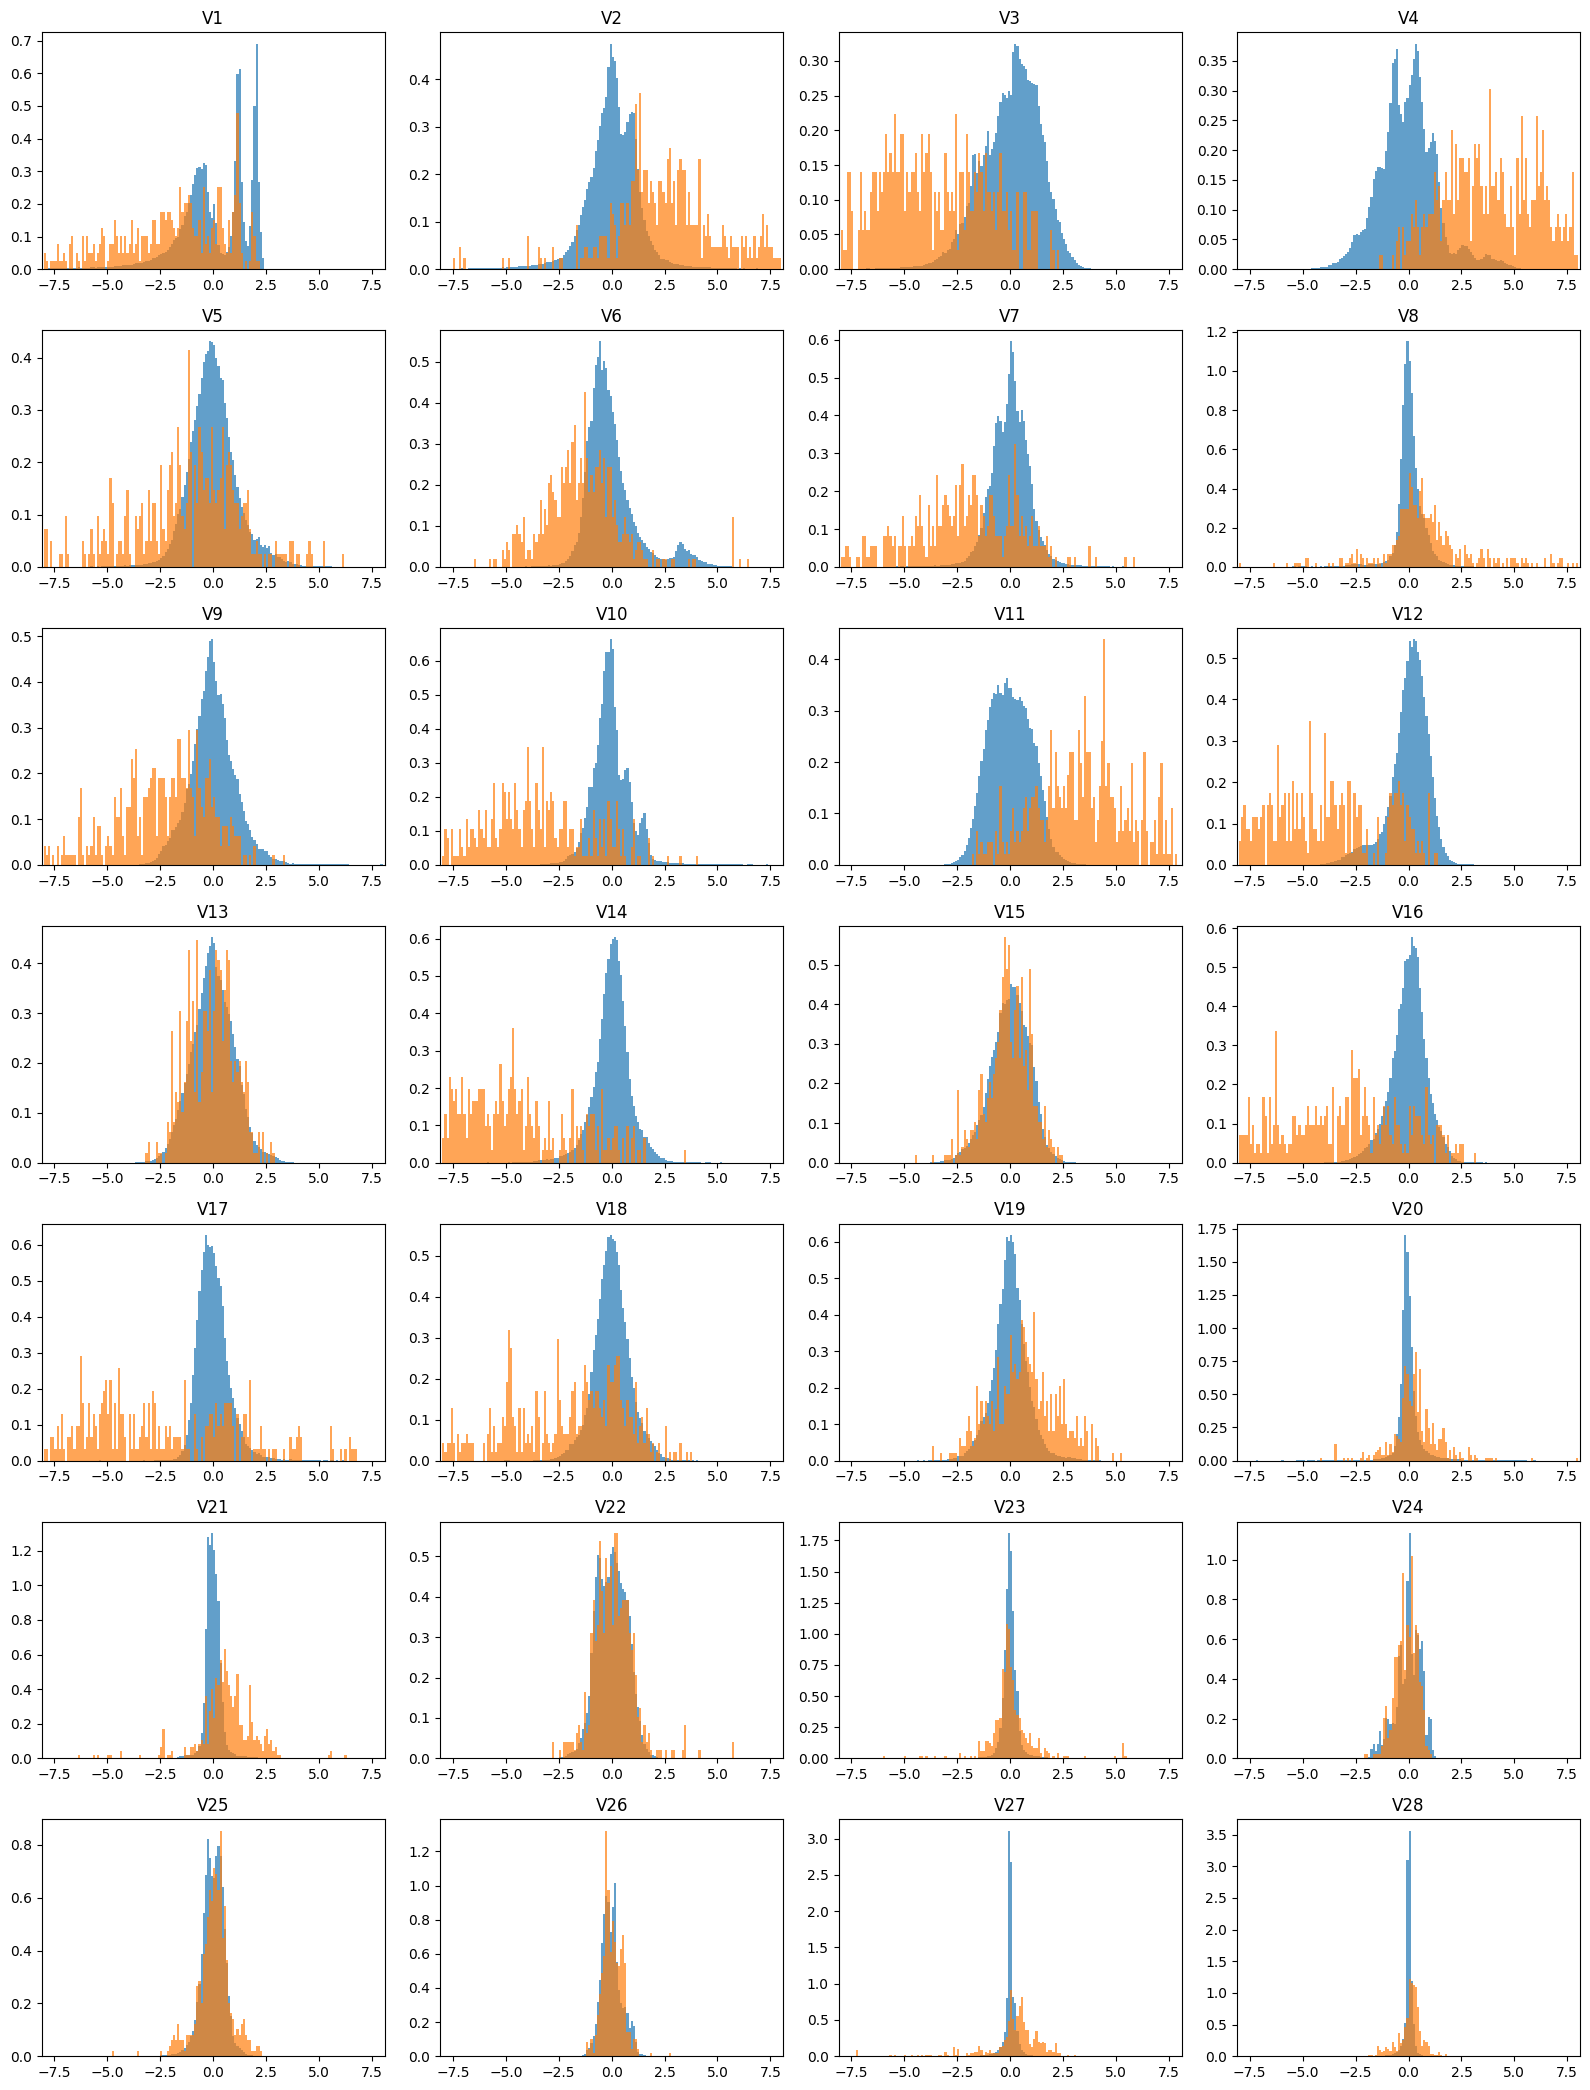

In [133]:
cols = df.drop(columns=["Time", "Amount", "Class"]).columns
bins = np.arange(-8, 8.1, 0.1)

n_cols = 4
n_rows = (len(cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    ax.hist(df[df["Class"]==0][col], bins=bins, alpha=0.7, density=True)
    ax.hist(df[df["Class"]==1][col], bins=bins, alpha=0.7, density=True)
    ax.set_title(col)
    ax.set_xlim(-8.1, 8.1)

# remove unused axes
for ax in axes[len(cols):]:
    ax.remove()

plt.tight_layout()
plt.show()


<div align="center">

**Figure - Feature distributions**

Blue = non-frauds, Orange = Frauds.
</div>

## EDA - Conclusion

By exploring the data we were able to:  
  
-Outline the challenges of class imbalance and temporal structure  
-Get initial insight into consumer/fraudster behavior  
-Check for data quality issues  
-Inform our modeling and evaluation choices  
  
Next, we will make our first attempt at a prediction model with a basic Logistic Regression.